In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")   

---
### Произведем объединение первичных данных

In [2]:
# Загрузка данных
def load_data():
    customers = pd.read_csv("./clean_data/customers.csv")
    geolocation = pd.read_csv("./clean_data/geolocation.csv")
    order_pay = pd.read_csv("./clean_data/order_payments.csv")
    reviews = pd.read_csv("./clean_data/order_reviews.csv")
    orders = pd.read_csv("./clean_data/orders.csv")
    item = pd.read_csv("./clean_data/orders_items.csv")
    category_name = pd.read_csv(
        "./clean_data/product_category_name_translation.csv")
    products = pd.read_csv("./clean_data/products.csv")
    sellers = pd.read_csv("./clean_data/sellers.csv")
    return customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers


In [3]:
# Объединение данных
def merge_data(orders, item, order_pay, reviews, products, customers, sellers, category_name):
    df = orders.merge(item, on='order_id', how='left')
    df = df.merge(order_pay, on='order_id', how='outer', validate='m:m')
    df = df.merge(reviews, on='order_id', how='outer')
    df = df.merge(products, on='product_id', how='outer')
    df = df.merge(customers, on='customer_id', how='outer')
    df = df.merge(sellers, on='seller_id', how='outer')
    df = df.merge(category_name, on="product_category_name", how="left")
    return df

In [4]:
# Очистка данных: удаление строк без customer_unique_id
def filter_customers(df):
    return df[~df["customer_unique_id"].isna()]

In [5]:
# Главная функция пайплайна
def main_pipeline():
    # Шаг 1: Загрузка данных
    customers, geolocation, order_pay, reviews, orders, item, category_name, products, sellers = load_data()

    # Шаг 2: Объединение данных
    df = merge_data(orders, item, order_pay, reviews, products,
                    customers, sellers, category_name)

    # Шаг 3: Фильтрация данных
    df = filter_customers(df)

    final_data = df

    return final_data

In [6]:
data = main_pipeline()

In [7]:
data.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,3c7e305796add66698959fc7ad176f6b,87502.0,umuarama,PR,9080.0,santo andre,SP,small_appliances
1,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9de5797cddb92598755a0f76383ddbbb,35490.0,entre rios de minas,MG,9080.0,santo andre,SP,small_appliances
2,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9915eb9f74b6c11aaf04833f65b00e93,38600.0,paracatu,MG,9080.0,santo andre,SP,small_appliances
3,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools
4,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,2.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools
5,4dcbd5ebfc13eef35e0fcb0ca1c2807e,033be315f82e41697260be39939d3662,delivered,2017-10-22 16:39:09,2017-10-23 17:49:12,2017-10-24 21:03:32,2017-11-08 18:28:44,2017-11-16 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,acfca8c3549ceceba9e125afc0349610,81530.0,curitiba,PR,29156.0,cariacica,ES,garden_tools
6,99a50db34d17b1f845a8ea04de3e747d,075b39e18f6c41df500a6ae613a735da,delivered,2017-10-09 08:16:17,2017-10-09 08:28:19,2017-10-16 18:35:57,2017-10-24 13:32:58,2017-11-09 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,6d30fb7a44f6405e3df4ec6a5a1c787c,44670.0,anguera,BA,29156.0,cariacica,ES,garden_tools
7,48ac23662de1f4a94e29e7f3452a85d9,093c2d35fa85b871eb936417a82a1ad2,delivered,2017-08-11 14:16:43,2017-08-11 14:30:16,2017-08-14 17:23:56,2017-08-26 15:27:28,2017-09-06 00:00:00,1.0,0da9ffd92214425d880de3f94e74ce39,...,12.0,42.0,fd65dc867fc1c42c8421fae7fb4eba67,44024.0,feira de santana,BA,29156.0,cariacica,ES,construction_tools_construction
8,bb13fa2703eaccdcb1e263eab3be6de4,0c3dfc99f2187c03f0e115be04ab0d72,delivered,2017-09-10 20:19:02,2017-09-10 20:30:23,2017-09-12 22:14:58,2017-09-22 17:42:05,2017-09-28 00:00:00,1.0,e251ebd2858be1aa7d9b2087a6992580,...,14.0,43.0,eb69ead1e0da68c941a67677f6a39f3b,6162.0,osasco,SP,29156.0,cariacica,ES,garden_tools
9,dfeb385531b47a17e24ab43992ebf15e,0d9c4b5c91997a61af84d12d72e91fc7,delivered,2018-07-12 21:38:26,2018-07-12 21:50:17,2018-07-13 13:32:00,2018-07-20 17:28:28,2018-08-03 00:00:00,1.0,d32f22e03fb01595aa10383f4364d303,...,13.0,40.0,dd47740f3c285d15d8c9c72fc204e78a,31035.0,belo horizonte,MG,29156.0,cariacica,ES,construction_tools_construction


In [8]:
# Приводим столбцы к нужному типу данных
data['order_purchase_timestamp'] = pd.to_datetime(
    data['order_purchase_timestamp'])
data['customer_unique_id'] = data['customer_unique_id'].astype(str)

# Убираем строки с отсутствующими customer_id или order_purchase_timestamp
data = data.dropna()

In [9]:
# Проверим пропуски
data.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timestamp          0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm   

In [10]:
# Проверим дублидубли
data.duplicated().sum()

0

In [11]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-09-29 15:53:03,2017-10-07 16:12:47,2017-10-30 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,3c7e305796add66698959fc7ad176f6b,87502.0,umuarama,PR,9080.0,santo andre,SP,small_appliances
1,7f39ba4c9052be115350065d07583cac,d7fc82cbeafea77bd0a8fbbf6296e387,delivered,2017-10-18 08:16:34,2017-10-18 23:56:20,2017-10-20 14:29:01,2017-10-27 16:46:05,2017-11-09 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9de5797cddb92598755a0f76383ddbbb,35490.0,entre rios de minas,MG,9080.0,santo andre,SP,small_appliances
2,9dc8d1a6f16f1b89874c29c9d8d30447,d9442164acf4b03109425633efaa0cfc,delivered,2017-10-12 13:33:22,2017-10-12 13:49:22,2017-10-17 15:42:42,2017-10-24 20:17:44,2017-11-06 00:00:00,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,...,43.0,36.0,9915eb9f74b6c11aaf04833f65b00e93,38600.0,paracatu,MG,9080.0,santo andre,SP,small_appliances
3,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,1.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools
4,0f548bd29148ebc519d6495e37a284e1,015faf9ec36eccd957c0f2782aab09a4,delivered,2017-09-03 08:06:30,2017-09-03 08:25:50,2017-09-04 22:03:06,2017-09-08 16:26:55,2017-09-27 00:00:00,2.0,08574b074924071f4e201e151b152b4e,...,12.0,39.0,dce323533e45e74d215e0fe7fb114118,24710.0,sao goncalo,RJ,29156.0,cariacica,ES,garden_tools


---
# Расчет RFM-показателей

RFM анализ делается на основе трех важнейших метрик:

Recency (R): Как недавно клиент совершал покупку.
Frequency (F): Сколько раз клиент покупал.
Monetary (M): Сумма покупок клиента.

In [12]:
# Получаем текущую дату
current_date = data['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Группируем данные по уникальным идентификаторам клиентов
rfm = data.groupby('customer_unique_id').agg({
    # Recency
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,
    'order_id': 'count',  # Frequency
    'payment_value': 'sum'  # Monetary
}).rename(columns={
    'order_purchase_timestamp': 'recency',
    'order_id': 'frequency',
    'payment_value': 'monetary'
}).reset_index()

# Классификация RFM

Используем квантильный анализ для сегментации клиентов на основе RFM значений.

---
### Интерпретация сегментов для оттока

### 1. Структура RFM-оценки
Каждый клиент получает 3 цифры в формате `R_F_M`, где:
- **R (Recency)** - ранг давности последней покупки:
  - 4: Совсем недавно (наилучший)
  - 1: Очень давно (наихудший)
- **F (Frequency)** - ранг частоты покупок:
  - 4: Очень часто
  - 1: Очень редко
- **M (Monetary)** - ранг суммы покупок:
  - 4: Очень много тратит
  - 1: Очень мало тратит

### 2. Логика распределения по рискам

| Категория риска   | Примеры RFM-оценок      | Логика интерпретации                                                                 |
|--------------------|-------------------------|--------------------------------------------------------------------------------------|
| **Высокий риск**   | '111', '112', '121'     | Низкие ранги по всем параметрам: давно не покупал, редко покупает, малые траты       |
| **Средний риск**   | '131', '211', '213'     | Смешанные показатели: например, недавняя покупка (R=2), но низкая частота (F=1)      |
| **Низкий риск**    | '311', '333', '444'     | Высокие ранги хотя бы по одному ключевому параметру (обычно Recency)                 |



In [13]:
# Применяем квантильный анализ
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, labels=False, duplicates='drop')
rfm['f_quartile'] = pd.qcut(
    rfm['frequency'], 4, labels=False, duplicates='drop')
rfm['m_quartile'] = pd.qcut(
    rfm['monetary'], 4, labels=False, duplicates='drop')

# Рассчитываем RFM score
rfm['rfm_score'] = rfm[['r_quartile', 'f_quartile', 'm_quartile']].sum(axis=1)

# Рассчитываем взвешенную RFM-оценку
weights = {'R': 0.5, 'F': 0.3, 'M': 0.2}
rfm['RFM_Weighted'] = (
    rfm['r_quartile']*weights['R']
    + rfm['f_quartile']*weights['F']
    + rfm['m_quartile']*weights['M']
)

# Автоматическая классификация через квантили
rfm['Churn_Risk'] = pd.qcut(
    rfm['RFM_Weighted'],
    q=[0, 0.25, 0.75, 1],  # Границы квантилей
    labels=['Высокий риск', 'Средний риск', 'Низкий риск']
)


In [14]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,RFM_Weighted,Churn_Risk
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,0,0,2,2,0.4,Высокий риск
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,1,0,0,1,0.5,Высокий риск
2,0000f46a3911fa3c0805444483337064,537,1,86.22,3,0,1,4,1.7,Низкий риск
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,0,0,2,1.0,Средний риск
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,0,2,4,1.4,Средний риск


---
# ABC-анализ

Используем ABC-анализ, чтобы определить, какие клиенты составляют важнейшую часть дохода (80/20 правило).

In [15]:
# Сортируем клиентов по денежному вкладу
rfm = rfm.sort_values('monetary', ascending=False)

# Рассчитываем кумулятивный процент
rfm['cumulative_value'] = rfm['monetary'].cumsum()
total_value = rfm['monetary'].sum()
rfm['cumulative_percent'] = rfm['cumulative_value'] / total_value * 100

# ABC-классификация
def assign_abc_category(row):
    if row['cumulative_percent'] <= 80:
        return 'A'
    elif row['cumulative_percent'] <= 95:
        return 'B'
    else:
        return 'C'


rfm['abc_class'] = rfm.apply(assign_abc_category, axis=1)

display(rfm.head(10))

,customer_unique_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,RFM_Weighted,Churn_Risk,cumulative_value,cumulative_percent,abc_class
3656,0a0a92112bd4c708ca5fde585afaa872,334,8,109312.64,2,0,3,5,1.6,Низкий риск,109312.64,0.562911,A
70137,c402f431464c72e27330a67f7b94d4fb,188,20,44048.00,1,0,3,4,1.1,Средний риск,153360.64,0.789739,A
22941,4007669dec559734d6f53e029e360987,279,6,36489.24,2,0,3,5,1.6,Низкий риск,189849.88,0.977642,A
85690,ef8d54b3797ea4db1d63f0ced6a906e9,133,10,30186.00,1,0,3,4,1.1,Средний риск,220035.88,1.133087,A
42295,763c8b1c9c68a0229c42c9fc6f662b93,46,4,29099.52,0,0,3,3,0.6,Средний риск,249135.40,1.282936,A
71661,c8460e4251689ba205045f3ea17884a1,22,24,27935.46,0,0,3,3,0.6,Средний риск,277070.86,1.426791,A
84036,eae0a83d752b1dd32697e0e7b4221656,127,15,25051.89,1,0,3,4,1.1,Средний риск,302122.75,1.555798,A
21953,3d47f4368ccc8e1bb4c4a12dbda7111b,331,10,22346.60,2,0,3,5,1.6,Низкий риск,324469.35,1.670873,A
62256,adfa1cab2b2c8706db21bb13c0a1beb1,89,6,19457.04,0,0,3,3,0.6,Средний риск,343926.39,1.771068,A
5524,0f5ac8d5c31de21d2f25e24be15bbffb,276,18,19342.26,2,0,3,5,1.6,Низкий риск,363268.65,1.870672,A


---
# XYZ-анализ

XYZ-анализ позволяет идентифицировать стабильность потребления каждого клиента, это можно сделать на основе частоты покупок.

In [16]:
# Сначала рассчитываем стандартное отклонение
rfm['std_dev'] = data.groupby('customer_unique_id')[
    'payment_value'].transform(lambda x: x.std())

# Затем присваиваем категории
rfm['x_category'] = pd.cut(rfm['std_dev'],
                           bins=[-1, 0.01, 50, float('inf')],
                           labels=['X', 'Y', 'Z'])

display(rfm.head())

,customer_unique_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,RFM_Weighted,Churn_Risk,cumulative_value,cumulative_percent,abc_class,std_dev,x_category
3656,0a0a92112bd4c708ca5fde585afaa872,334,8,109312.64,2,0,3,5,1.6,Низкий риск,109312.64,0.562911,A,0.000000,X
70137,c402f431464c72e27330a67f7b94d4fb,188,20,44048.00,1,0,3,4,1.1,Средний риск,153360.64,0.789739,A,NaN,NaN
22941,4007669dec559734d6f53e029e360987,279,6,36489.24,2,0,3,5,1.6,Низкий риск,189849.88,0.977642,A,70.355904,Z
85690,ef8d54b3797ea4db1d63f0ced6a906e9,133,10,30186.00,1,0,3,4,1.1,Средний риск,220035.88,1.133087,A,17.741309,Y
42295,763c8b1c9c68a0229c42c9fc6f662b93,46,4,29099.52,0,0,3,3,0.6,Средний риск,249135.40,1.282936,A,NaN,NaN


> Так как у нас большая часть клиентов с 1 покупкой, закономерно что у них стандартное отклонение пропущено, что ломает алгоритм присвоения категории, посему присвоим им кастомную категорию Single_Purchase

In [17]:
# Новый список категорий, включая 'Single Purchase'
new_categories = ['X', 'Y', 'Z', 'Single Purchase']

# Создаем x_category как категориальный тип с новыми категориями
rfm['x_category'] = pd.cut(
    rfm['std_dev'],
    bins=[-1, 0.01, 50, float("inf")],
    labels=['X', 'Y', 'Z'],
    include_lowest=True
)

# Добавляем новую категорию
rfm['x_category'] = rfm['x_category'].cat.add_categories(['Single Purchase'])

# Заполняем NaN значения в x_category значением 'Single Purchase'
rfm['x_category'] = rfm['x_category'].fillna('Single Purchase')

# Убедитесь, что x_category является категориальным типом с учетом всех категорий
rfm['x_category'] = pd.Categorical(
    rfm['x_category'], categories=new_categories)

# Отображение данных и количества клиентов в каждой категории
display(rfm.head())
display(rfm["x_category"].value_counts())

,customer_unique_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,RFM_Weighted,Churn_Risk,cumulative_value,cumulative_percent,abc_class,std_dev,x_category
3656,0a0a92112bd4c708ca5fde585afaa872,334,8,109312.64,2,0,3,5,1.6,Низкий риск,109312.64,0.562911,A,0.000000,X
70137,c402f431464c72e27330a67f7b94d4fb,188,20,44048.00,1,0,3,4,1.1,Средний риск,153360.64,0.789739,A,NaN,Single Purchase
22941,4007669dec559734d6f53e029e360987,279,6,36489.24,2,0,3,5,1.6,Низкий риск,189849.88,0.977642,A,70.355904,Z
85690,ef8d54b3797ea4db1d63f0ced6a906e9,133,10,30186.00,1,0,3,4,1.1,Средний риск,220035.88,1.133087,A,17.741309,Y
42295,763c8b1c9c68a0229c42c9fc6f662b93,46,4,29099.52,0,0,3,3,0.6,Средний риск,249135.40,1.282936,A,NaN,Single Purchase


x_category
Single Purchase    63203
X                  16966
Y                   7611
Z                   3685
Name: count, dtype: int64

---
# Сегментация клиентов

Теперь мы можем сегментировать клиентов на основе их RFM и ABC / XYZ класса.

In [18]:
segments = rfm.copy()

segments['abc_class'] = segments['abc_class'].astype(str)
segments['x_category'] = segments['x_category'].astype(str)

segments['segment'] = segments['abc_class'] + "_" + segments['x_category']

In [19]:
segments.head()


,customer_unique_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,RFM_Weighted,Churn_Risk,cumulative_value,cumulative_percent,abc_class,std_dev,x_category,segment
3656,0a0a92112bd4c708ca5fde585afaa872,334,8,109312.64,2,0,3,5,1.6,Низкий риск,109312.64,0.562911,A,0.000000,X,A_X
70137,c402f431464c72e27330a67f7b94d4fb,188,20,44048.00,1,0,3,4,1.1,Средний риск,153360.64,0.789739,A,NaN,Single Purchase,A_Single Purchase
22941,4007669dec559734d6f53e029e360987,279,6,36489.24,2,0,3,5,1.6,Низкий риск,189849.88,0.977642,A,70.355904,Z,A_Z
85690,ef8d54b3797ea4db1d63f0ced6a906e9,133,10,30186.00,1,0,3,4,1.1,Средний риск,220035.88,1.133087,A,17.741309,Y,A_Y
42295,763c8b1c9c68a0229c42c9fc6f662b93,46,4,29099.52,0,0,3,3,0.6,Средний риск,249135.40,1.282936,A,NaN,Single Purchase,A_Single Purchase


In [20]:
segments["segment"].value_counts()

segment
A_Single Purchase    26548
B_Single Purchase    21283
C_Single Purchase    15372
A_X                   7110
B_X                   5652
C_X                   4204
A_Y                   3180
B_Y                   2572
C_Y                   1859
A_Z                   1450
B_Z                   1308
C_Z                    927
Name: count, dtype: int64

### Расшифровка сегментов

1. **A_Single Purchase**:
   - **Описание**: Клиенты, которые совершили всего одну покупку, но относятся к высокоприбыльной категории, то есть имеют высокий суммарный денежный объем (monetary).
   - **Стратегия**: Эти клиенты могут быть потенциальными кандидатами для повторных покупок. Вам следует рассмотреть возможность быстрое предложение, чтобы они совершили повторную покупку.

2. **B_Single Purchase**:
   - **Описание**: Клиенты с одной покупкой, находящиеся в средней ценовой категории.
   - **Стратегия**: Предоставьте им стимулы или скидки на ваш товар с целью сделать их постоянными клиентами.

3. **C_Single Purchase**:
   - **Описание**: Клиенты с одной покупкой, относящиеся к более низкому денежному объему.
   - **Стратегия**: Проведите дополнительные маркетинговые исследования, чтобы выяснить, почему они сделали только одну покупку и попытайтесь повысить их интерес к вашему продукту.

4. **A_X**:
   - **Описание**: Клиенты, которые совершили несколько покупок и имеют высокий денежный объем транзакций, с низким стандартным отклонением в своих покупках.
   - **Стратегия**: Выделите их для программы лояльности или постоянного поощрения, чтобы сохранить высокий уровень менеджмента.

5. **B_X**:
   - **Описание**: Клиенты с хорошей частотой покупок и средним денежным объемом, с низкой вариативностью.
   - **Стратегия**: Они являются достойными вниманию, поскольку могут стать постоянными клиентами. Убедитесь, что они видят ценность в вашем продукте, и предложите их специальные предложения.

6. **C_X**:
   - **Описание**: Клиенты с более низкой частотой покупок, относящиеся к категории с низким денежным объемом, но с минимальным стандартным отклонением.
   - **Стратегия**: Проводите акции или предоставляйте информацию о вашем товаре, чтобы вдохновить их на повторные покупки.

7. **A_Y**:
   - **Описание**: Высокоприбыльные клиенты с некоторой вариативностью в своих покупках.
   - **Стратегия**: Персонализированные предложения и коммуникации помогут удержать этих клиентов.

8. **B_Y**:
   - **Описание**: Клиенты со средней частотой и доходом, с некоторой вариативностью.
   - **Стратегия**: Постарайтесь понять, что именно привлекает их и почему они могут не оставаться постоянными.

9. **C_Y**:
   - **Описание**: Клиенты с низким денежным объемом и частотой, но с падением в стандартном отклонении.
   - **Стратегия**: Оцените, нужны ли им персонализированные предложения, или необходимо провести дополнительные исследования для понимания их нужд.

10. **A_Z**:
    - **Описание**: Высокоприбыльные клиенты с большой вариативностью в своих покупках.
    - **Стратегия**: Инвестируйте усилия в сохранение этих клиентов, так как они могут быть подвержены колебаниям своих предпочтений.

11. **B_Z**:
    - **Описание**: Средние клиенты с высокой вариативностью покупок.
    - **Стратегия**: Понимание, какие факторы влияют на их покупательское поведение, может помочь персонализировать их предложения.

12. **C_Z**:
    - **Описание**: Клиенты с низкой частотой и объемом покупок, но с высокой вариативностью.
    - **Стратегия**: Это клиенты, которые, возможно, нуждаются в дополнительном внимании и акциях, чтобы увеличить их участие.

In [21]:
segment_descriptions = {
    'A_Single Purchase': 'Клиенты с одной покупкой, высокий денежный объем.',
    'B_Single Purchase': 'Клиенты с одной покупкой, средний денежный объем.',
    'C_Single Purchase': 'Клиенты с одной покупкой, низкий денежный объем.',
    'A_X': 'Высокоприбыльные клиенты, низкая вариативность.',
    'B_X': 'Клиенты со средней частотой и объемом, низкая вариативность.',
    'C_X': 'Клиенты с низким объемом, низкая вариативность.',
    'A_Y': 'Высокоприбыльные клиенты с разумной вариативностью.',
    'B_Y': 'Средние клиенты с некоторой вариативностью.',
    'C_Y': 'Клиенты с низким объемом и частотой, но с вариативностью.',
    'A_Z': 'Высокоприбыльные клиенты с большой вариативностью.',
    'B_Z': 'Средние клиенты с высокой вариативностью.',
    'C_Z': 'Низкие клиенты с высокой вариативностью.',
}

# добавление расшифровки в таблицу
segments['segment_description'] = segments['segment'].map(segment_descriptions)

# Посмотрим на обновленную таблицу
display(segments.head())

,customer_unique_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,RFM_Weighted,Churn_Risk,cumulative_value,cumulative_percent,abc_class,std_dev,x_category,segment,segment_description
3656,0a0a92112bd4c708ca5fde585afaa872,334,8,109312.64,2,0,3,5,1.6,Низкий риск,109312.64,0.562911,A,0.000000,X,A_X,"Высокоприбыльные клиенты, низкая вариативность."
70137,c402f431464c72e27330a67f7b94d4fb,188,20,44048.00,1,0,3,4,1.1,Средний риск,153360.64,0.789739,A,NaN,Single Purchase,A_Single Purchase,"Клиенты с одной покупкой, высокий денежный объем."
22941,4007669dec559734d6f53e029e360987,279,6,36489.24,2,0,3,5,1.6,Низкий риск,189849.88,0.977642,A,70.355904,Z,A_Z,Высокоприбыльные клиенты с большой вариативнос...
85690,ef8d54b3797ea4db1d63f0ced6a906e9,133,10,30186.00,1,0,3,4,1.1,Средний риск,220035.88,1.133087,A,17.741309,Y,A_Y,Высокоприбыльные клиенты с разумной вариативно...
42295,763c8b1c9c68a0229c42c9fc6f662b93,46,4,29099.52,0,0,3,3,0.6,Средний риск,249135.40,1.282936,A,NaN,Single Purchase,A_Single Purchase,"Клиенты с одной покупкой, высокий денежный объем."


In [22]:
segments["segment_description"].value_counts()

segment_description
Клиенты с одной покупкой, высокий денежный объем.               26548
Клиенты с одной покупкой, средний денежный объем.               21283
Клиенты с одной покупкой, низкий денежный объем.                15372
Высокоприбыльные клиенты, низкая вариативность.                  7110
Клиенты со средней частотой и объемом, низкая вариативность.     5652
Клиенты с низким объемом, низкая вариативность.                  4204
Высокоприбыльные клиенты с разумной вариативностью.              3180
Средние клиенты с некоторой вариативностью.                      2572
Клиенты с низким объемом и частотой, но с вариативностью.        1859
Высокоприбыльные клиенты с большой вариативностью.               1450
Средние клиенты с высокой вариативностью.                        1308
Низкие клиенты с высокой вариативностью.                          927
Name: count, dtype: int64

In [23]:
segments.to_csv("./labels/rfm_abc_xyz.csv", index=False)

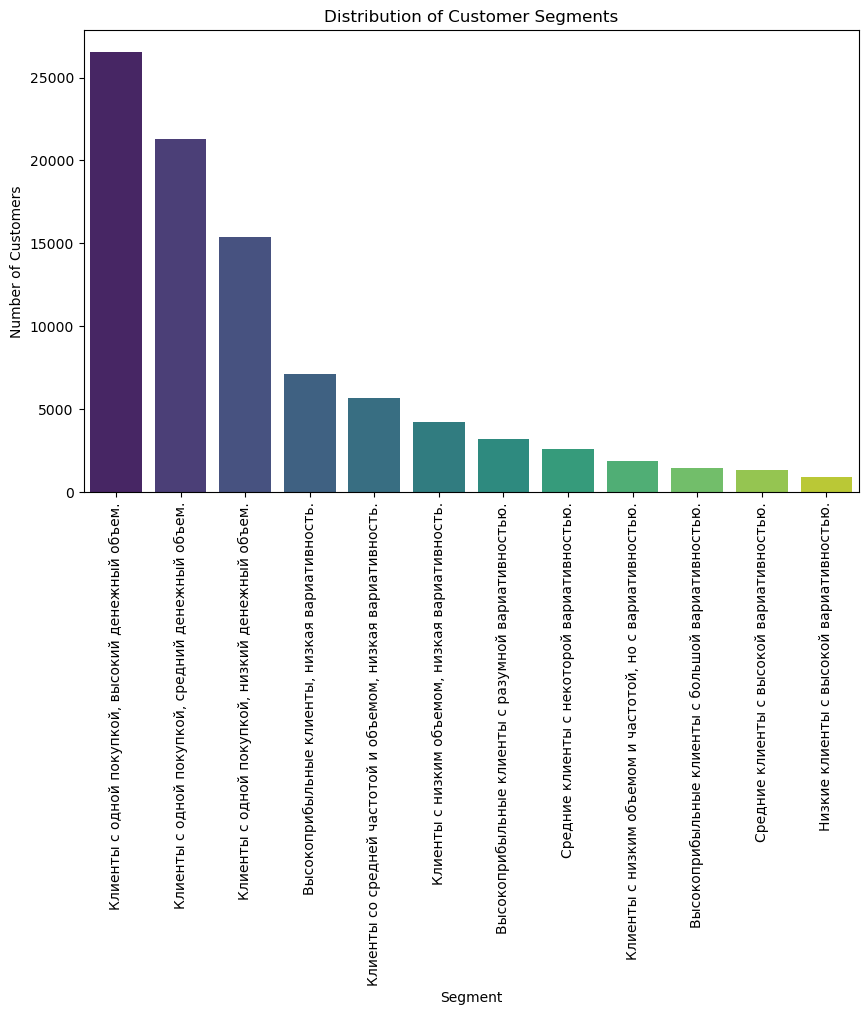

In [24]:
# Визуализация распределения по сегментам
plt.figure(figsize=(10, 6))
sns.countplot(data=segments, x='segment_description', order=segments['segment_description'].value_counts().index, palette='viridis')
plt.title('Distribution of Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.show()

In [26]:
rfm

,customer_unique_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score,RFM_Weighted,Churn_Risk,cumulative_value,cumulative_percent,abc_class,std_dev,x_category
3656,0a0a92112bd4c708ca5fde585afaa872,334,8,109312.64,2,0,3,5,1.6,Низкий риск,1.093126e+05,0.562911,A,0.000000,X
70137,c402f431464c72e27330a67f7b94d4fb,188,20,44048.00,1,0,3,4,1.1,Средний риск,1.533606e+05,0.789739,A,NaN,Single Purchase
22941,4007669dec559734d6f53e029e360987,279,6,36489.24,2,0,3,5,1.6,Низкий риск,1.898499e+05,0.977642,A,70.355904,Z
85690,ef8d54b3797ea4db1d63f0ced6a906e9,133,10,30186.00,1,0,3,4,1.1,Средний риск,2.200359e+05,1.133087,A,17.741309,Y
42295,763c8b1c9c68a0229c42c9fc6f662b93,46,4,29099.52,0,0,3,3,0.6,Средний риск,2.491354e+05,1.282936,A,NaN,Single Purchase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14509,2878e5b88167faab17d4fb83a986d38b,304,1,11.63,2,0,0,2,1.0,Средний риск,1.941911e+07,99.999783,C,0.000000,X
39876,6f5b9d1cdccc4d28f0483a612edecacf,361,1,11.63,3,0,0,3,1.5,Средний риск,1.941913e+07,99.999843,C,1.628128,Y
64154,b33336f46234b24a613ad9064d13106d,69,1,10.89,0,0,0,0,0.0,Высокий риск,1.941914e+07,99.999899,C,17.281690,Y
67650,bd06ce0e06ad77a7f681f1a4960a3cc6,350,1,10.07,3,0,0,3,1.5,Средний риск,1.941915e+07,99.999951,C,NaN,Single Purchase


In [ ]:
# Подсчет количества клиентов по категориям риска
risk_distribution = rfm['Churn_Risk'].value_counts()
#risk_distribution.to_csv("./labels/risk_distr.csv", index=False)
print(risk_distribution)

Churn_Risk
Средний риск    45665
Высокий риск    23053
Низкий риск     22747
Name: count, dtype: int64


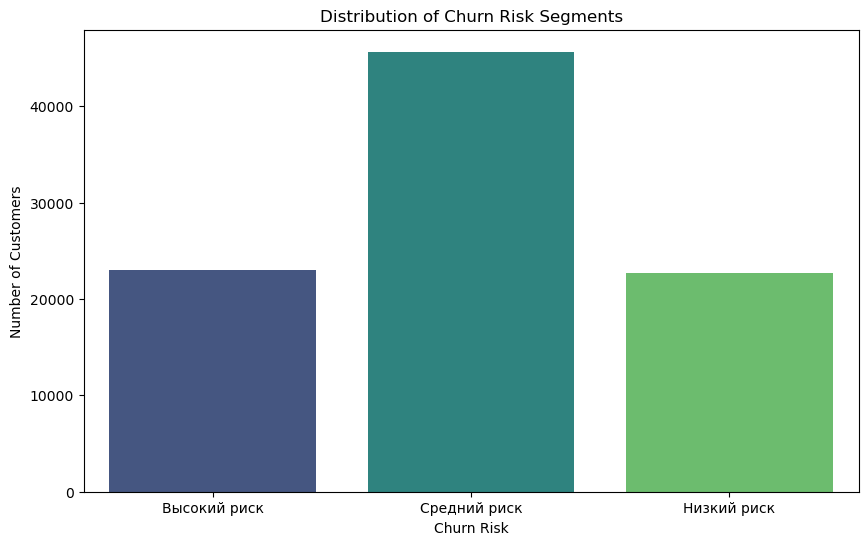

In [185]:
# Визуализация распределения по категориям риска
plt.figure(figsize=(10, 6))
sns.countplot(data=segments, x='Churn_Risk', palette='viridis')
plt.title('Distribution of Churn Risk Segments')
plt.xlabel('Churn Risk')
plt.ylabel('Number of Customers')
plt.show()